In [1]:
import ee
import os
import requests
import zipfile
import io
from datetime import datetime
import rasterio
import numpy as np
import random
import rasterio
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

## Initial Set up

In [14]:
# Authenticate the first time using: earthengine authenticate
ee.Initialize(project='ee-ashleys10125')

# Define region of interest (replace with your geometry)
# roi = ee.Geometry.Rectangle([149.6439790925943,-34.56176623172756,151.7588472566568,-32.29735063827625]) # Syndey
roi = ee.Geometry.Rectangle([-119.26506179877703,33.3171028209172,-116.72172683783953,34.50010605791834]) # LA Fires


# # Date range
# start_date = '2019-07-01'
# end_date = '2023-07-1'

# # Lagged Date (2 Weeks behind)
# lagged_start = '2019-06-17'
# lagged_end = '2023-06-16'

# Date range for L.A fires
start_date = '2025-01-07'
end_date = '2025-02-01'

# Lagged Date (2 Weeks behind)
lagged_start = '2024-12-24'
lagged_end = '2025-01-18'


# Output folder
output_folder = './cal-fires'
os.makedirs(output_folder, exist_ok=True)

In [ ]:
import datetime

# Helper function to get 2 Weeks back
first_img = fire_ic.sort('system:time_start').first()
last_img = fire_ic.sort('system:time_start', False).first()

# Convert image timestamps to ee.Date
first_date = ee.Date(first_img.get('system:time_start'))
last_date = ee.Date(last_img.get('system:time_start'))

millis_to_date = lambda m: datetime.datetime.utcfromtimestamp(m['value'] / 1000).date()

print("First date:", millis_to_date(first_date.advance(-14,"day").getInfo()))
print("Last date:", millis_to_date(last_date.advance(-14,"day").getInfo()))

C:\Users\vince\AppData\Local\Temp\ipykernel_71432\3950617292.py:11: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  millis_to_date = lambda m: datetime.datetime.utcfromtimestamp(m['value'] / 1000).date()


First date: 2024-12-24
Last date: 2025-01-17


### Image Collection

In [15]:
fire_ic = ee.ImageCollection("MODIS/061/MOD14A1") \
    .filterDate(start_date, end_date) \
    .filterBounds(roi) \
    .select("FireMask")

# Lagged 2 weeks behind
ref_ic = ee.ImageCollection("MODIS/061/MOD09GA") \
    .filterDate(lagged_start, lagged_end) \
    .filterBounds(roi) \
    .select(['sur_refl_b01', 'sur_refl_b02', 'sur_refl_b03'])  # Red, NIR, Blue

lst_ic = ee.ImageCollection("MODIS/061/MOD11A1") \
    .filterDate(lagged_start, lagged_end) \
    .filterBounds(roi) \
    .select("LST_Day_1km")

### Initial Collection

In [17]:
def process_image(date_img):
    img = ee.Image(date_img)
    date = img.date()
    lagged_date = date.advance(-14,"day")

    fire = fire_ic.filterDate(date, date.advance(1, 'day')).first()
    red_nir = ref_ic.filterDate(lagged_date, lagged_date.advance(1, 'day')).first()
    lst = lst_ic.filterDate(lagged_date, lagged_date.advance(1, 'day')).first()

    red = ee.Image(red_nir).select('sur_refl_b01').multiply(0.0001)
    nir = ee.Image(red_nir).select('sur_refl_b02').multiply(0.0001)
    blue = ee.Image(red_nir).select('sur_refl_b03').multiply(0.0001)

    ndvi = nir.subtract(red).divide(nir.add(red)).rename("NDVI")
    evi = nir.subtract(red).divide(
        nir.add(red.multiply(6)).subtract(blue.multiply(7.5)).add(1).multiply(2.5)
    ).rename("EVI")

    combined = ee.Image.cat([ndvi, fire, lst, evi]) \
        .clip(roi) \
        .set('system:time_start', date.millis())

    return combined

### Download Data

In [18]:
dates = fire_ic.toList(fire_ic.size())
nimg = fire_ic.size().getInfo()

for i in range(nimg):
    print(f"Processing image {i + 1} of {nimg}")

    img = ee.Image(dates.get(i))
    date_str = img.date().format('yyyy-MM-dd').getInfo()

    combined_img = process_image(img)

    # Create download URL
    url = combined_img.toFloat().getDownloadURL({
        'name': f'combined_{date_str}',
        'region': roi,
        'scale': 1000,
        'filePerBand': False
    })

    print(f"Downloading: {url}")

    # Download and unzip
    response = requests.get(url)
    with zipfile.ZipFile(io.BytesIO(response.content)) as z:
        z.extractall(output_folder)

    print(f"Saved to {output_folder}")


Processing image 1 of 25
Downloading: https://earthengine.googleapis.com/v1/projects/ee-ashleys10125/thumbnails/5d2c26292ed9362fd0e26b6403d8685c-6a9454de823bdd1ee855e4d34d787c57:getPixels
Saved to ./cal-fires
Processing image 2 of 25
Downloading: https://earthengine.googleapis.com/v1/projects/ee-ashleys10125/thumbnails/df9e2e7fbdaf53fe152edddd6ebb45cf-866de240fde1cdab2dba1d64fb0fa47a:getPixels
Saved to ./cal-fires
Processing image 3 of 25
Downloading: https://earthengine.googleapis.com/v1/projects/ee-ashleys10125/thumbnails/2de53f2c99ffd926908522b673e44ff3-f12721295a72d5a7f9f3986dff74b94c:getPixels
Saved to ./cal-fires
Processing image 4 of 25
Downloading: https://earthengine.googleapis.com/v1/projects/ee-ashleys10125/thumbnails/5a6849c820203b580bf4bb6c53d023d4-7ceb840137a03508f1f7fdfdabd20948:getPixels
Saved to ./cal-fires
Processing image 5 of 25
Downloading: https://earthengine.googleapis.com/v1/projects/ee-ashleys10125/thumbnails/cc3802cf528ba34ebd2b6f1b8805094e-036145ec2d677fb2b23

## Testing

Number of bands: 4
CRS: PROJCS["MODIS Sinusoidal",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Sinusoidal"],PARAMETER["longitude_of_center",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
Resolution: (999.9999999999999, 1000.0000000000003)


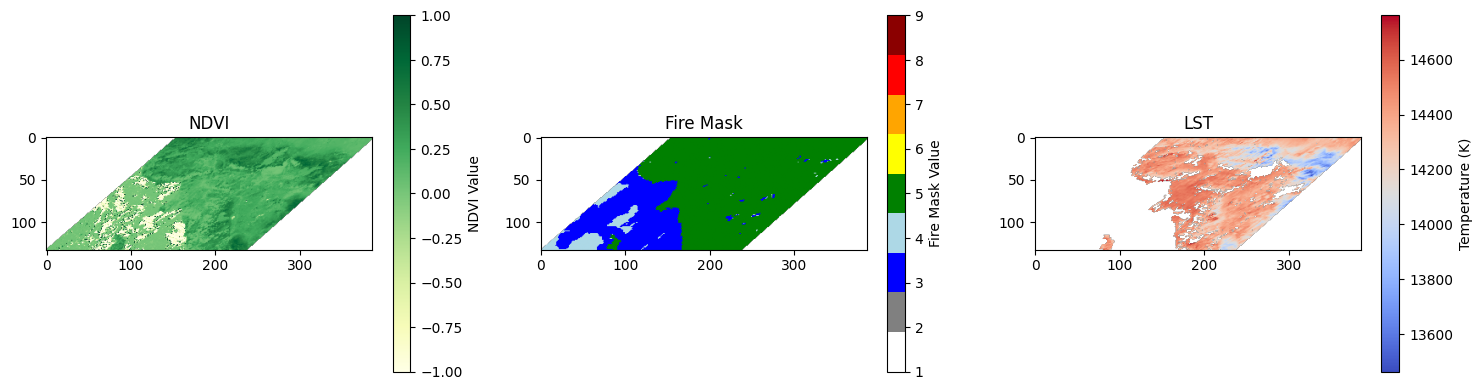

In [25]:
file_path = './cal-fires/combined_2025-01-31.tif'
with rasterio.open(file_path) as src:
    print(f"Number of bands: {src.count}")
    print(f"CRS: {src.crs}")
    print(f"Resolution: {src.res}")

    # Read all bands into a NumPy array
    bands = src.read()

    # Read individual bands (1-based indexing)
    ndvi = src.read(1)  # Band 1: NDVI
    firemask = src.read(2)  # Band 2: FireMask
    lst = src.read(3)  # Band 3: Land Surface Temp

    fire_mask_cmap = mcolors.ListedColormap([
        'white',    # 1: Not processed
        'gray',     # 2: Not processed
        'blue',     # 3: Non-fire water
        'lightblue', # 4: Cloud
        'green',    # 5: Non-fire land
        'yellow',   # 6: Unknown
        'orange',   # 7: Fire (low confidence)
        'red',      # 8: Fire (nominal confidence)
        'darkred'   # 9: Fire (high confidence)
    ])
    bounds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


# Plot the data
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# NDVI plot
cax1 = axes[0].imshow(ndvi, cmap='YlGn', vmin=-1, vmax=1)
axes[0].set_title("NDVI")
fig.colorbar(cax1, ax=axes[0], orientation='vertical', label="NDVI Value")

# Fire Mask plot
cax2 = axes[1].imshow(firemask, cmap=fire_mask_cmap, vmin=1, vmax=9)
axes[1].set_title("Fire Mask")
fig.colorbar(cax2, ax=axes[1], orientation='vertical', label="Fire Mask Value")

# LST plot
cax3 = axes[2].imshow(lst, cmap='coolwarm')
axes[2].set_title("LST")
fig.colorbar(cax3, ax=axes[2], orientation='vertical', label="Temperature (K)")

plt.tight_layout()
plt.show()

# Create Patches

In [36]:
from sklearn.model_selection import train_test_split
from scipy.ndimage import rotate
from sklearn.utils import resample
from sklearn.utils import shuffle

In [27]:
import numpy as np

def remove_outliers(patch, lower=1, upper=99):
    finite_mask = np.isfinite(patch)
    patch_finite = patch[finite_mask]
    
    # Fallback if all values are non-finite (NaN/inf/-inf)
    if len(patch_finite) == 0:
        return np.nan_to_num(patch, nan=0, posinf=0, neginf=0)
    
    p_low = np.percentile(patch_finite, lower)
    p_high = np.percentile(patch_finite, upper)
    
    clipped = np.clip(patch, p_low, p_high)
    
    return np.nan_to_num(clipped, nan=0)

def normalize_patch(ndvi_patch, temp_patch, evi_patch):
    # Remove outliers first
    ndvi_patch = remove_outliers(ndvi_patch)
    temp_patch = remove_outliers(temp_patch)
    evi_patch = remove_outliers(evi_patch)

    # Normalize with band-specific logic
    ndvi_norm = (ndvi_patch + 1) / 2  # NDVI-specific
    temp_norm = (temp_patch - 12500) / (17500 - 12500)
    evi_min, evi_max = np.nanmin(evi_patch), np.nanmax(evi_patch)
    if evi_max == evi_min:
        evi_norm = np.zeros_like(evi_patch) 
    else:
        evi_norm = (evi_patch - evi_min) / (evi_max - evi_min)

    return ndvi_norm, temp_norm, evi_norm

def generate_augmented_patches(ndvi, temp, evi, fire):
    augmented = []
    for flip in [None, 'h']:
        for angle in [0, 90, 180, 270]:
            ndvi_aug, temp_aug, evi_aug, fire_aug = ndvi.copy(), temp.copy(), evi.copy(), fire.copy()
            if flip == 'h':
                ndvi_aug, temp_aug, evi_aug, fire_aug = map(np.fliplr, [ndvi_aug, temp_aug, evi_aug, fire_aug])
            if angle != 0:
                ndvi_aug = rotate(ndvi_aug, angle, reshape=False)
                temp_aug = rotate(temp_aug, angle, reshape=False)
                evi_aug = rotate(evi_aug, angle, reshape=False)
                fire_aug = rotate(fire_aug, angle, reshape=False, order=0)

            input_patch = np.stack([ndvi_aug, temp_aug, evi_aug], axis=-1)
            label_patch = np.where(np.isin(fire_aug, [7, 8, 9]), 1, 0)
            augmented.append((input_patch, label_patch))
    return augmented

In [56]:
dataset_folder = output_folder
patch_size = 32 # old: 32

X_fire, y_fire = [], []
X_nofire, y_nofire = [], []

for tif_file in os.listdir(dataset_folder):
    if not tif_file.endswith('.tif'):
        continue

    with rasterio.open(os.path.join(dataset_folder, tif_file)) as src:
        ndvi_mask = src.read(1)
        fire_mask = src.read(2)
        temp_mask = src.read(3)
        evi_mask = src.read(4)

    height, width = fire_mask.shape
    for i in range(height // patch_size):
        for j in range(width // patch_size):
            y0, y1 = i * patch_size, (i + 1) * patch_size
            x0, x1 = j * patch_size, (j + 1) * patch_size

            ndvi = ndvi_mask[y0:y1, x0:x1]
            fire = fire_mask[y0:y1, x0:x1]
            temp = temp_mask[y0:y1, x0:x1]
            evi = evi_mask[y0:y1, x0:x1]

            # Skip if mostly empty or NDVI/Temp is all zero or NaN
            invalid_fire = np.all((fire == 0) | np.isnan(fire))
            invalid_ndvi = np.all((ndvi == 0) | np.isnan(ndvi))
            invalid_temp = np.all((temp == 0) | np.isnan(temp) | np.isinf(temp))
            invalid_evi = np.all((evi == 0) | np.isnan(evi))

            if invalid_ndvi or invalid_temp or invalid_fire:
                continue

            # Normalize and clean
            ndvi, temp, evi = normalize_patch(ndvi, temp, evi)

            fire_binary = np.where(np.isin(fire, [7, 8, 9]), 1, 0)
            input_patch = np.stack([ndvi, temp, evi], axis=-1)

            variances = np.var(input_patch, axis=(0, 1))
            if np.any(np.isinf(variances)):
                continue
            
            if np.any(fire_binary == 1):
                for aug_input, aug_label in generate_augmented_patches(ndvi, temp, evi, fire):
                    if np.all(aug_input == 0): # skip empty augmnetations
                        continue
                    X_fire.append(aug_input)
                    y_fire.append(np.any(aug_label == 1).astype(np.uint8))
            else:
                X_nofire.append(input_patch)
                y_nofire.append(0)

In [57]:
print(len(X_fire))
print(len(X_nofire))

120
580


# Resampling and Train/Test/Split

In [ ]:
# fire to non-fire ratio
ratio = 2

X_nofire, y_nofire = resample(
    X_nofire, y_nofire,
    replace=False,
    n_samples=ratio*len(X_fire),
)

In [ ]:
# Combine
X = np.array(X_fire + X_nofire)
y = np.array(y_fire + y_nofire)

# === First Split: Train + Temp (for further splitting) and Test ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y
)

# # === Second Split: Train and Validation (from Temp) ===
# X_train, X_val, y_train, y_val = train_test_split(
#     X_temp, y_temp, test_size=0.25, stratify=y_temp  # 0.25 of 0.8 = 0.2 overall
# )

# === Print Stats ===
print(f"Train: {X_train.shape}, Test: {X_test.shape}")
print(f"Fire ratio - Train: {np.mean(y_train):.2f}, Test: {np.mean(y_test):.2f}")


In [58]:
# FOR L.A FIRES (NO TRAINING OR TESTING)
# Combine
X = np.array(X_fire + X_nofire)
y = np.array(y_fire + y_nofire)

# Shuffle
X, y = shuffle(X, y)

# Saving

In [59]:
# Your local folder path (modify as needed)
save_path = "./data_splits"
os.makedirs(save_path, exist_ok=True)

# # Save all sets into one compressed file
# np.savez_compressed(
#     os.path.join(save_path, "cal_fires.npz"),
#     X_train=X_train, y_train=y_train,
#     X_test=X_test, y_test=y_test
# )

np.savez_compressed(
    os.path.join(save_path, "cal_fires_32x32.npz"),
    X_data = X, y_data = y
)

print("Datasets saved successfully to:", save_path)

Datasets saved successfully to: ./data_splits


# Testing

In [44]:
data = np.load("./data_splits/cal_fires.npz")
X_train = data["X_data"]
y_train = data["y_data"]

In [53]:
# Choose an index to visualize
idx = 24  # Change this as needed

print(y_train[idx])

1


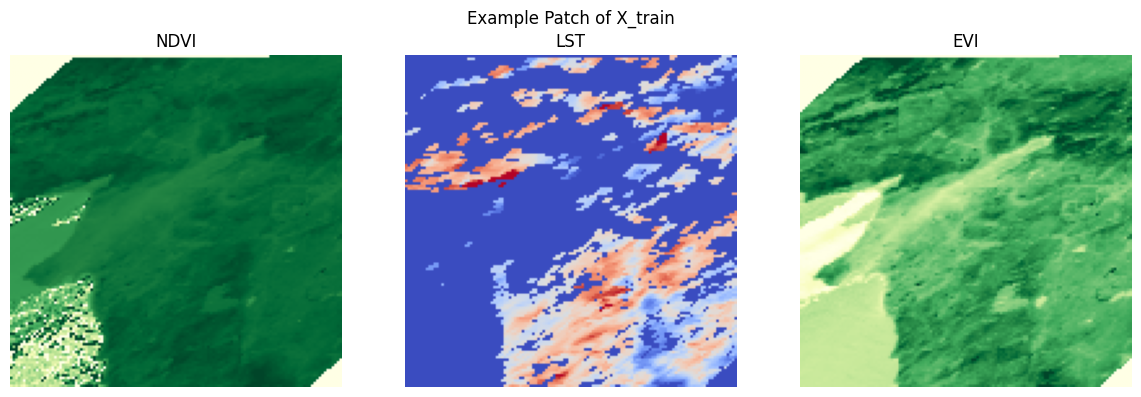

In [ ]:
import matplotlib.pyplot as plt

patch = X_train[idx]  # Shape: (height, width, 3)
titles = ['NDVI', 'LST', 'EVI']
cmaps = ['YlGn', 'coolwarm', 'YlGn']  # Better suited for each variable


fig, axs = plt.subplots(1, 3, figsize=(12, 4))
for i in range(3):
    im = axs[i].imshow(
        patch[:, :, i],
        cmap=cmaps[i]
    )
    axs[i].set_title(titles[i])
    axs[i].axis('off')

plt.suptitle("Patch")
plt.tight_layout()
plt.show()